# Notes on Decision Trees 

From Chapter 4 of Hands-On Machine Learning textbook by Aurelien Geron. 

## Load Data and Run Model

In [37]:
#run a basic decision tree classifier
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

iris = load_iris()
X = iris.data[:,2:] # petal length and width
y = iris.target

df_iris = pd.DataFrame(iris.data,columns=iris.feature_names)
print(df_iris.shape)
print(df_iris.head())

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,y)

(150, 4)
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [23]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'],
      dtype='<U10')

You can visualize the trained Decision Tree by first using the export_graphviz() method to output a
graph definition file called iris_tree.dot:

#### BUT first you need to create a custom function to change the graphviz executables. As, for some reason, conda installs them in the a different place than it normally does.  Fortunately you can do this easily with pypotplus's 'set_graphviz_executables' method.

In [29]:
#Move paths to the correct location
import os

base = 'C:\\Users\\mciniello\\AppData\\Local\\Continuum\\Anaconda3\\envs\\py36\\'
def conda_fix(graph):
        path = os.path.join(base, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)

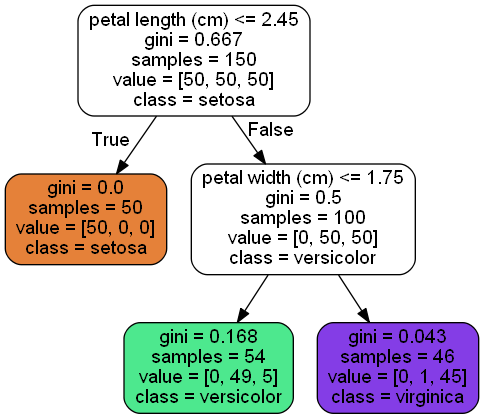

In [38]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#create empty .dot file
dot_data = StringIO()

export_graphviz(
        tree_clf,
        out_file=dot_data,
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True,
    )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
conda_fix(graph)
Image(graph.create_png())

A node’s samples attribute counts how many training instances it applies to. For example, 100
training instances have a petal length greater than 2.45 cm (depth 1, right), among which 54 have a
petal width smaller than 1.75 cm (depth 2, left). A node’s value attribute tells you how many training
instances of each class this node applies to: for example, the bottom-right node applies to 0 Iris-
Setosa, 1 Iris-Versicolor, and 45 Iris-Virginica. Finally, a node’s gini attribute measures its
impurity: a node is “pure” (gini=0) if all training instances it applies to belong to the same class.
For example, since the depth-1 left node applies only to Iris-Setosa training instances, it is pure and
its gini score is 0. Equation 6-1 shows how the training algorithm computes the gini score Gi of the
ith node. 

![](Pictures/gini.png)

- pi,k is the ratio of class k instances among the training instances in the ith node.

For example, the depth-2 left node has a gini score equal to 

**1 – (0/54)2 – (49/54)2 – (5/54)2 ≈ 0.168. **

Scikit-Learn uses the **CART algorithm, which produces only binary trees: nonleaf nodes always have two children (i.e.,
questions only have yes/no answers)**

<font color =red> However, other algorithms such as **ID3 can produce Decision Trees with nodes that
have more than two children.**</font>


Figure 6-2 shows this Decision Tree’s decision boundaries. The thick vertical line represents the
decision boundary of the root node (depth 0): petal length = 2.45 cm. Since the left area is pure (only
Iris-Setosa), it cannot be split any further. However, the right area is impure, so the depth-1 right node
splits it at petal width = 1.75 cm (represented by the dashed line). Since max_depth was set to 2, the
Decision Tree stops right there. **However, if you set max_depth to 3, then the two depth-2 nodes
would each add another decision boundary (represented by the dotted lines).**

![](Pictures/cart2.png)

### Estimating Class Probabilities

A Decision Tree can also estimate the probability that an instance belongs to a particular class k: first
it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training
instances of class k in this node. For example, suppose you have found a flower whose petals are 5
cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the Decision Tree
should output the following probabilities: 0% for Iris-Setosa (0/54), 90.7% for Iris-Versicolor
(49/54), and 9.3% for Iris-Virginica (5/54). And of course if you ask it to predict the class, it should
output Iris-Versicolor (class 1) since it has the highest probability. Let’s check this:

In [9]:
tree_clf.predict_proba([[5,1.5]])

array([[ 0.        ,  0.90740741,  0.09259259]])

In [10]:
tree_clf.predict([[5,1.5]])

array([1])

### The CART Algorithm
Scikit-Learn uses the Classification And Regression Tree (CART) algorithm to train Decision Trees
(also called “growing” trees). The idea is really quite simple: the algorithm first splits the training set
in two subsets using a single feature k and a threshold tk (e.g., “petal length ≤ 2.45 cm”). **How does it
choose k and tk? It searches for the pair (k, tk) that produces the purest subsets (weighted by their
size). The cost function that the algorithm tries to minimize is given by Equation 6-2.**

![](Pictures/Picture37.png)


So essentially it is trying to split the data based on the lowest gini coefficients (the greatest level of purity). G=0 means 0 inequality! Or only 1 class!

**Once it has successfully split the training set in two, it splits the subsets using the same logic, then the
sub-subsets and so on, recursively.** It **stops recursing once it reaches the maximum depth (defined by
the max_depth hyperparameter), or if it cannot find a split that will reduce impurity.** A few other
hyperparameters (described in a moment) control additional stopping conditions
(min_samples_split, min_samples_leaf, min_weight_fraction_leaf, and max_leaf_nodes).

As you can see, the CART algorithm is a greedy algorithm: it greedily searches for an optimum split at the top level, then
repeats the process at each level. It does not check whether or not the split will lead to the lowest possible impurity several
levels down. A greedy algorithm often produces a reasonably good solution, but it is not guaranteed to be the optimal
solution.

### Gini Impurity or Entropy?
By default, the Gini impurity measure is used, but you can select the entropy impurity measure instead
by setting the criterion hyperparameter to "entropy". **The concept of entropy originated in
thermodynamics as a measure of molecular disorder: entropy approaches zero when molecules are
still and well ordered.** It later spread to a wide variety of domains, including Shannon’s information
theory, where it measures the average information content of a message: entropy is zero when all
messages are identical. **In Machine Learning, it is frequently used as an impurity measure: a set’s
entropy is zero when it contains instances of only one class. SO YOU WANT TO FIND THE COLUMNS WITH THE LOWEST ENTROPY TO SPLIT ON FIRST!!!!**  
![](pictures/entorpy.png)
So should you use Gini impurity or entropy? <font color=red>The truth is, most of the time it does not make a big
difference: they lead to similar trees. Gini impurity is slightly faster to compute, so it is a good
default. However, when they differ, Gini impurity tends to isolate the most frequent class in its own
branch of the tree, while entropy tends to produce slightly more balanced trees.</font>

### Regularization Hyperparamters

**Decision Trees make very few assumptions about the training data (as opposed to linear models, which obviously assume that the data is linear, for example).** If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely, AND MOST LIKELY OVERFITTING IT!!!

<font color=red> <br> Such a model
is often called a nonparametric model, not because it does not have any parameters (it often has a
lot) but because **the number of parameters is not determined prior to training, so the model structure is
free to stick closely to the data**. In contrast, a parametric model such as a linear model has a
predetermined number of parameters, so **its degree of freedom is limited**, reducing the risk of
overfitting (but increasing the risk of underfitting).</font>

**To avoid overfitting the training data, you need to restrict the Decision Tree’s freedom during training.**
As you know by now, this is called regularization. The regularization hyperparameters depend on the
algorithm used, **but generally you can at least restrict the maximum depth of the Decision Tree.** In
Scikit-Learn, this is controlled by the max_depth hyperparameter (the default value is None, which
means unlimited). **Reducing max_depth will regularize the model and thus reduce the risk of
overfitting.**

<font color = blue><br>The DecisionTreeClassifier class has a few other parameters that similarly restrict the shape of
the Decision Tree:</font> 
- min_samples_split (the minimum number of samples a node must have before it can be split),
- min_samples_leaf (the minimum number of samples a leaf node must have),
- min_weight_fraction_leaf (same as min_samples_leaf but expressed as a fraction of the total number of weighted instances),
- max_leaf_nodes (maximum number of leaf nodes), and
- max_features (maximum number of features that are evaluated for splitting at each node).

** Increasing min_hyperparameters or reducing max_ hyperparameters will regularize the model.**

### Pruning a tree!!!
Other algorithms work by first training the Decision Tree without restrictions, then pruning (deleting) unnecessary nodes. **A
node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically
significant.** Standard statistical tests, such as the χ2 test, are used to estimate the probability that the improvement is purely the result of chance (which is called the null hypothesis). If this probability, called the p-value, is higher than a given threshold (typically 5%, controlled by a hyperparameter), then the node is considered unnecessary and its children are
deleted. The pruning continues until all unnecessary nodes have been pruned.

In [11]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

C:\Users\mciniello\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


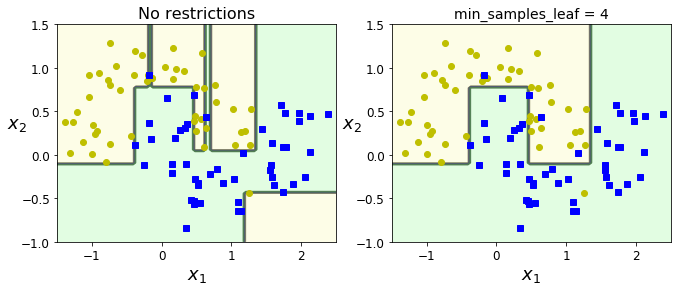

In [13]:
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

### Regression
Decision Trees are also capable of performing regression tasks. Let’s build a regression tree using Scikit-Learn’s DecisionTreeRegressor class, training it on a noisy quadratic dataset with max_depth=2:

In [20]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [21]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

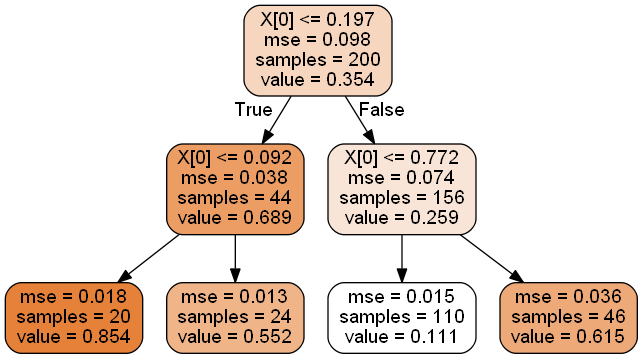

In [55]:
#create empty .dot file
dot_data = StringIO()

export_graphviz(
        tree_reg,
        out_file=dot_data,
        rounded=True,
        filled=True,
    )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
conda_fix(graph)
Image(graph.create_png())

This tree looks very similar to the classification tree you built earlier. The main difference is that instead of predicting a class in each node, it predicts a value. For example, suppose you want to make a prediction for a new instance with x1 = 0.6. You traverse the tree starting at the root, and you eventually reach the leaf node that predicts value=0.1106. <font color=red>**This prediction is simply the average target value of the 110 training instances associated to this leaf node. This prediction results in a Mean Squared Error (MSE) equal to 0.0151 over these 110 instances.**</font>

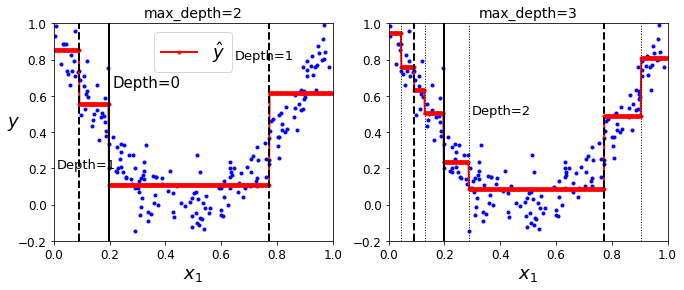

Notice how the predicted value for each region is ALWAYS the average target value of the instances in that regio
The algo splits each region in a way that makes most training instances as close as possible to that predicted value


In [23]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

print( 'Notice how the predicted value for each region is ALWAYS the average target value of the instances in that regio')
print('The algo splits each region in a way that makes most training instances as close as possible to that predicted value')

**The CART algo works mostly the same way as earlier, except that instead of trying to split the data in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE**

![](pictures/cart.png)

Just like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. Without any regularization (i.e., using the default hyperparameters), you get the predictions on the left of Figure 6-6. It is obviously overfitting the training set very badly. Just setting min_samples_leaf=10 results in a much more reasonable model.

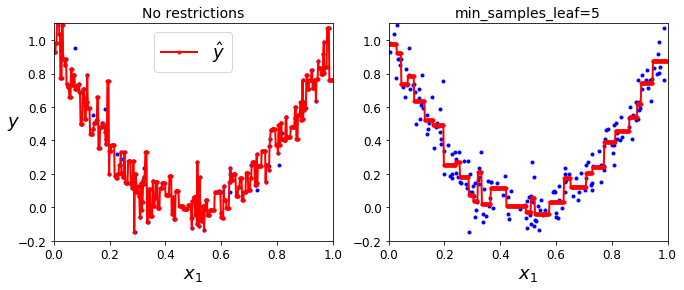

In [24]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=5)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

### Instability and limiations

A few key issues: **Decision Trees LOVE orthoganal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training rotation.**

More generally, the main issues with Decision Trees is that they are very sensitive to SMALL VARIATIONS in training data. For example, if you just remove the WIDEST IRIS VERISCOLOR from the iris training set (the one with perals 4.8 cm long and 1.8 cm wide) and train a new model, you get a whole new set of predictions... see  below. 

![](pictures/test.jpg)


**Random Forests can limit this instability by averaging predictions over many trees.**